<a href="https://colab.research.google.com/github/hxyder/xiaoyu/blob/main/%E2%80%9CXiaoyu_Han_fraudDetection_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Summary of Fraud Detection Code Lab
- Data is highly imbalanced
- Features of interval_after_signup and time related raw and aggregates are highly predictive of fraud
- Made actionable operation recommendations/proposal for business

# Part 1: Import Data 

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
!git clone https://github.com/loganlaioffer/fraudDetection.git

Cloning into 'fraudDetection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 2), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
!cd fraudDetection/
!ls fraudDetection/
!pip install -U imbalanced-learn
# !pip install pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

cv_data.csv   imbalancedFraudDF.csv	test_data.csv	tr_server_data.csv
cv_label.csv  IpAddress_to_Country.csv	test_label.csv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 7.6 MB/s 
     |████████████████████████████████| 199 kB 14.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 21.9 MB 206 kB/s
     |████████████████████████████████| 102 kB 7.8 MB/s 
     |████████████████████████████████| 690 kB 52.7 MB/s 
     |████████████████████████████████| 4.7 MB 43.7 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 812 kB 57.0 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=bc9c29527854e843f8dee4ff8cb49d713904c2f98b730489f834e1b8e64ec0b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mnrxh4c5/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=4900ef8a41154a13833539abf00888d26fce0147dddc826708dc32c4a5012e2a
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash

In [ ]:
# ipURL = 'https://github.com/loganlaioffer/fraudDetection/blob/master/IpAddress_to_Country.csv'
# fraudURL = 'https://github.com/loganlaioffer/fraudDetection/blob/master/imbalancedFraudDF.csv'

ip_Country = pd.read_csv('fraudDetection/IpAddress_to_Country.csv')
fraud_df = pd.read_csv('fraudDetection/imbalancedFraudDF.csv')

fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


# Part 2: Data exploration

In [ ]:
#Distribution of the label column
fraud_df['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [ ]:
fraud_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,138376.0,2.001490e+05,1.152268e+05,2.000000,1.008948e+05,2.000005e+05,2.997452e+05,4.000000e+05
purchase_value,138376.0,3.693899e+01,1.832109e+01,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02
age,138376.0,3.312587e+01,8.623645e+00,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01
ip_address,138376.0,2.154381e+09,1.250563e+09,52093.496895,1.085079e+09,2.156471e+09,3.249150e+09,4.294850e+09
class,138376.0,1.022576e-02,1.006045e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
#method 2
import pandas_profiling

#Inline summary report without saving report as object
pandas_profiling.ProfileReport(fraud_df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Task 1: Identify country info based on ip_address


In [ ]:

ip_Country.head(7)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan
6,16785408.0,16793599,China


In [ ]:

countries = []
for i in range(len(fraud_df)):
    ip_address = fraud_df.loc[i, 'ip_address']
    #check which interval does ip_address falls into
    #below [] is list of T/F, only when this ip_address falls into the correct internal row does the index generate a True
    #tmp is a df of shape n * 3, where n is 1 if found a match (ip_address falls in range) or 0 if no match
    tmp = ip_Country[(ip_Country['lower_bound_ip_address'] <= ip_address) &
                    (ip_Country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        



In [ ]:
fraud_df['country'] = countries

In [ ]:
#check 
ip_address = fraud_df.loc[7,'ip_address']
tmp = ip_Country[(ip_Country['lower_bound_ip_address'] <= ip_address) &
                    (ip_Country['upper_bound_ip_address'] >= ip_address)]
print(tmp)

        lower_bound_ip_address  upper_bound_ip_address country
138561            3.719037e+09              3719299071   China


In [ ]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [ ]:
print(fraud_df.user_id.nunique())#138376
print(len(fraud_df.index))#138376
#all of the user_id has only the first 1 transaction

138376
138376


# Part 3a: Feature Engineering





In [ ]:
# more features
# no interaction between other row, so we can do it first
fraud_df['interval_after_signup'] = (pd.to_datetime(fraud_df['purchase_time']) - pd.to_datetime(
        fraud_df['signup_time'])).dt.total_seconds()

fraud_df['signup_days'] = pd.DatetimeIndex(fraud_df['signup_time']).dayofyear


fraud_df['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_df['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_df['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_df['signup_time']).hour

fraud_df['purchase_days'] = pd.DatetimeIndex(fraud_df['purchase_time']).dayofyear
fraud_df['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_df['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_df['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_df['purchase_time']).hour

fraud_df = fraud_df.drop(['user_id','signup_time','purchase_time'], axis=1)

In [ ]:
fraud_df.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


In [ ]:
print(fraud_df.source.value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


# Part 4: Data Split

In [ ]:
y = fraud_df['class']
X = fraud_df.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#check the shape
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [ ]:
X_train['country'].value_counts(ascending=True)

Benin                 1
Yemen                 1
Fiji                  1
Monaco                1
Madagascar            1
                  ...  
United Kingdom     3253
Japan              5251
China              8876
NA                16275
United States     42348
Name: country, Length: 177, dtype: int64

In [ ]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day
29343,12,OULPAZAFRFPXP,Ads,Chrome,M,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648
12190,10,AIIWMFEYQQIEB,Ads,Opera,M,29,1.686759e+09,United States,6766039.0,5,78146,84,18585
19388,34,VUVETBUPCIWJE,Direct,Chrome,M,53,4.138429e+09,NA,5870515.0,197,81354,265,76669
89104,48,QCFULAJOYKFUU,Ads,Chrome,M,29,9.617337e+07,France,2145618.0,160,30920,185,16538
82082,44,IHRWLMIJMEEEU,Ads,FireFox,M,24,1.936025e+09,China,7079059.0,111,71897,193,66156


# Part 3b: Feature Engineering


Convert categorical features with high cadinality to numericals

In [ ]:

X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train['num_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)# number of times device_id occurred in train data

# the more a ip is shared, the more suspicious
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna=False)
X_train['num_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# the less visit from a country, the more suspicious
X_train_country_mapping = X_train.country.value_counts(dropna=False)
X_train['num_country_shared'] = X_train.country.map(X_train_country_mapping)#lots of NAs in country column, #without dropna=False will produce nan in this col


X_train = X_train.drop(['device_id','ip_address','country'], axis=1)




In [ ]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,num_dev_shared,num_ip_shared,num_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,1,1,3075
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,1,1,42348
19388,34,1,53,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0,1,1,16275
89104,48,1,29,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0,1,1,2322
82082,44,1,24,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0,1,1,8876


In [ ]:
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)


# the more a device is shared, the more suspicious
X_test['num_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['num_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['num_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)


In [ ]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,num_dev_shared,num_ip_shared,num_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,1,1,3075
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,1,1,42348
19388,34,1,53,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0,1,1,16275
89104,48,1,29,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0,1,1,2322
82082,44,1,24,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0,1,1,8876


normalization


In [ ]:
# # normalize (min-max) to [0,1]

#Compute the train minimum and maximum
scaler = preprocessing.MinMaxScaler().fit(X_train[['num_dev_shared', 'num_ip_shared', 'num_country_shared']]) 
print(scaler.data_max_)

#transform the training data and test data and use them for the model training
X_train[['num_dev_shared', 'num_ip_shared', 'num_country_shared']] = scaler.transform(X_train[['num_dev_shared', 'num_ip_shared', 'num_country_shared']])


X_test[['num_dev_shared', 'num_ip_shared', 'num_country_shared']] = scaler.transform(X_test[['num_dev_shared', 'num_ip_shared', 'num_country_shared']])



[6.0000e+00 6.0000e+00 4.2348e+04]


In [ ]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,num_dev_shared,num_ip_shared,num_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,0.0,0.0,0.072591
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,0.0,0.0,1.000000
19388,34,1,53,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0,0.0,0.0,0.384301
89104,48,1,29,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0,0.0,0.0,0.054809
82082,44,1,24,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0,0.0,0.0,0.209578


In [ ]:
X_test.head()

,purchase_value,sex,age,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,num_dev_shared,num_ip_shared,num_country_shared
10224,19,1,34,4311302.0,190,36985,240,28287,1,0,0,0,0,0,0,1,0.0,0.0,0.094812
85132,31,0,41,4079557.0,75,48284,122,67041,1,0,0,1,0,0,0,0,0.0,0.0,0.094812
45717,29,1,30,6104979.0,58,68033,129,38612,1,0,0,1,0,0,0,0,0.0,0.0,0.008218
62898,74,0,27,5206591.0,135,42763,195,65354,0,0,1,0,0,1,0,0,0.0,0.0,0.252060
6553,39,0,35,292543.0,201,59280,205,6223,0,1,0,0,0,1,0,0,0.0,0.0,0.033344


In [ ]:
X_train.num_dev_shared.value_counts(dropna=False)

0.0    105427
0.2      4774
0.4       324
0.6       124
0.8        45
1.0         6
Name: num_dev_shared, dtype: int64

In [ ]:
X_test.num_dev_shared.value_counts(dropna=False)

0.0    27330
0.2      334
0.4       12
Name: num_dev_shared, dtype: int64

# Part 5: Model Training


Simple LogisticRegression model

In [ ]:

lGR = LogisticRegression()

lGR.fit(X_train,y_train)

y_pred=lGR.predict(X_test)

In [ ]:
confu_matrix = metrics.confusion_matrix(y_test, y_pred)
df_confu = pd.DataFrame(confu_matrix, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(df_confu)

        pred_0  pred_1
true_0   27389       0
true_1     287       0


Simple RF model

In [ ]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

probs = classifier_RF.predict_proba(X_test)
predicted = classifier_RF.predict(X_test)

In [ ]:
# predict class labels 0/1 for the test set
("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:,1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix: ")
confu_matrix = confusion_matrix(y_test, predicted)
df_confu = pd.DataFrame(confu_matrix, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(df_confu)
print('recall =',float(confu_matrix[1,1])/(confu_matrix[1,0]+confu_matrix[1,1]))
print('precision =', float(confu_matrix[1,1])/(confu_matrix[1,1] + confu_matrix[0,1]))

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))

f1_score is: : 0.6712962962962962
confusion_matrix: 
        pred_0  pred_1
true_0   27389       0
true_1     142     145
recall = 0.5052264808362369
precision = 1.0
accuracy_score is: : 0.9948692007515537


SMOTE sampling

In [ ]:

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


In [ ]:
#RF with smoted training data
sm_rf = RandomForestClassifier(random_state=0)

sm_rf.fit(X_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = sm_rf.predict(X_test)

# generate class probabilities
probs_sm = sm_rf.predict_proba(X_test)



In [ ]:

# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))#string to int

print ("confusion_matrix_sm: ")
confu_sm = confusion_matrix(y_test, predicted_sm)
confu_df = pd.DataFrame(confu_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(confu_df)
print('recall or sens_sm =',float(confu_sm[1,1])/(confu_sm[1,0]+confu_sm[1,1]))
print('precision_sm =', float(confu_sm[1,1])/(confu_sm[1,1] + confu_sm[0,1]))

accuracy_score_sm is: : 0.9948330683624801
roc_auc_score_sm is: : 0.7676158935089662
f1_score_sm is: : 0.6697459584295612
confusion_matrix_sm: 
        pred_0  pred_1
true_0   27388       1
true_1     142     145
recall or sens_sm = 0.5052264808362369
precision_sm = 0.9931506849315068


# Part 6: Parameter tuning by GridSearchCV

In [ ]:

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
    
}

In [ ]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    confu_matrix = confusion_matrix(y_test, y_pred)
    df_confu = pd.DataFrame(confu_matrix, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(df_confu)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(confu_matrix[1,1]) / (confu_matrix[1,0] + confu_matrix[1,1]))
    print('precision = ', float(confu_matrix[1,1]) / (confu_matrix[1,1] + confu_matrix[0,1]))

    return grid_search



Optimizing on f1_score on LR

In [ ]:
LRGrid = {"C" : np.logspace(-2,10,20), "penalty":["l1","l2"]}

logRegModel = LogisticRegression(random_state=0)

lrg_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score='f1_score') #LOL

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for f1_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     287       0
	roc_auc_score is: : 0.749596438866388
	f1_score is: : 0.0
recall =  0.0
precision =  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Optimizing on f1_score on RF

In [ ]:
parameters = {        
'max_depth': [1, 5, 15],
'n_estimators' :  [10,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

clf = RandomForestClassifier(random_state=0)

In [ ]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
	roc_auc_score is: : 0.7943879400196651
	f1_score is: : 0.6712962962962962
recall =  0.5052264808362369
precision =  1.0


In [ ]:
best_rf_f1 = grid_search_rf_f1.best_estimator_
best_rf_f1

RandomForestClassifier(class_weight={0: 1, 1: 0.2}, max_depth=5,
                       n_estimators=150, random_state=0)

In [ ]:
f1_results = pd.DataFrame(grid_search_rf_f1.cv_results_)
sorted_f1 = f1_results.sort_values(by='mean_test_f1_score', ascending=False)
sorted_f1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()




,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
9,1.000,0.527,0.690,1.0,0.527,0.690,5,"{0: 1, 1: 1}",150
3,1.000,0.527,0.690,1.0,0.527,0.690,5,"{0: 1, 1: 0.2}",150
5,1.000,0.527,0.690,1.0,0.560,0.718,15,"{0: 1, 1: 0.2}",150
11,1.000,0.527,0.690,1.0,0.584,0.737,15,"{0: 1, 1: 1}",150
4,0.995,0.527,0.689,1.0,0.602,0.752,15,"{0: 1, 1: 0.2}",10


In [ ]:
#Var Importance, make a guess?
pd.DataFrame(best_rf_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)




,importance
interval_after_signup,0.575224
purchase_days,0.181321
num_ip_shared,0.111570
num_dev_shared,0.087757
signup_days,0.016174
purchase_seconds_of_day,0.010831
signup_seconds_of_day,0.006662
purchase_value,0.003175
age,0.002221
num_country_shared,0.001906


Optimizing recall_score on RF

In [ ]:
grid_rf_recall = grid_search_wrapper(clf, parameters, refit_score='recall_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27146     243
true_1     132     155
	roc_auc_score is: : 0.7904661234456265
	f1_score is: : 0.4525547445255475
recall =  0.5400696864111498
precision =  0.38944723618090454


In [ ]:
best_RF_recall = grid_rf_recall.best_estimator_
best_RF_recall

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=5,
                       n_estimators=150, random_state=0)

In [ ]:
# predict class labels for the test set
predicted_recall = best_RF_recall.predict(X_test)

# generate class probabilities
probs_recall = best_RF_recall.predict_proba(X_test)

recall_result = pd.DataFrame(grid_rf_recall.cv_results_)
sorted_recall = recall_result.sort_values(by='mean_test_recall_score', ascending=False)
sorted_recall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
15,0.159,0.636,0.254,0.164,0.656,0.262,5,"{0: 1, 1: 100}",150
14,0.160,0.633,0.255,0.162,0.652,0.260,5,"{0: 1, 1: 100}",10
12,0.303,0.609,0.340,0.291,0.615,0.334,1,"{0: 1, 1: 100}",10
13,0.422,0.543,0.475,0.421,0.543,0.474,1,"{0: 1, 1: 100}",150
16,0.675,0.533,0.593,0.759,0.813,0.782,15,"{0: 1, 1: 100}",10


# Tasks 3: Fraud Characteristics

In [ ]:

train_df = pd.concat([X_train, y_train], axis=1)
pd.crosstab(train_df["num_dev_shared"],train_df["class"])
#the larger num_dev_shared, the higher rate of fraud

class,0,1
num_dev_shared,,
0.0,104966,461
0.2,4403,371
0.4,152,172
0.6,37,87
0.8,13,32
1.0,1,5


In [ ]:

fraud_df.groupby("class")[['interval_after_signup']].mean()

,interval_after_signup
class,
0,5.191179e+06
1,2.570226e+06


In [ ]:
fraud_df.groupby("class")[['interval_after_signup']].median()
#more than half of fraud happened 1s after signed up

,interval_after_signup
class,
0,5194911.0
1,1.0


In [ ]:
fraud_df[fraud_df['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days,signup_seconds_of_day,purchase_days,purchase_seconds_of_day
136961,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,218,80113,257,38465
136962,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,NA,1.0,12,4207,12,4208
136963,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,49,40723,137,77593
136964,34,QHEODGCAVJKIQ,SEO,Chrome,M,37,9.408096e+08,1,United States,1.0,12,77710,12,77711
136965,76,DAKVYHKIEYRBH,SEO,Chrome,F,48,6.361041e+08,1,Hungary,1.0,10,48421,10,48422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137056,21,AIGPGDVRDKOKT,SEO,FireFox,F,45,3.058136e+09,1,India,1.0,2,69762,2,69763
137057,52,PQGKGQACIARBV,Ads,Chrome,F,36,7.203338e+08,1,China,1.0,9,77018,9,77019
137058,54,XHZBVWFWHSGTQ,SEO,FireFox,M,50,2.249217e+09,1,United States,1.0,1,32483,1,32484
137059,10,WETYPHOQVLWMK,Ads,FireFox,M,36,2.293333e+09,1,United States,1.0,7,63914,7,63915


#Task 4: How to use the prediction


recommended:
green: 1 - 3 pass
grey: 4-7 need manual investigation
red: 8,9 decline

In [ ]:

t = (10 * probs_recall[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)

print(np.asarray((unique, counts)).T)



[[    1     1]
 [    2 24555]
 [    3  2623]
 [    4    99]
 [    5   177]
 [    6    76]
 [    7     1]
 [    8    20]
 [    9   124]]


In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgclf = XGBClassifier()
xgclf.fit(X_train,y_train)

XGBClassifier()

In [ ]:
train_predict = xgclf.predict(X_train)
test_predict = xgclf.predict(X_test)
from sklearn import metrics


print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))


confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)


The accuracy of the Logistic Regression is: 0.9951761517615176
The accuracy of the Logistic Regression is: 0.9948692007515537
The confusion matrix result:
 [[27389   142]
 [    0   145]]


In [ ]:
learning_rate = [0.001]
subsample = [0.8]  #0.9
colsample_bytree = [0.6]#0.8
max_depth = [3] #,5,8,15

parameters = { 'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree':colsample_bytree,
              'max_depth': max_depth}
model = XGBClassifier(n_estimators = 150)  

grid_xg = grid_search_wrapper(xgclf, parameters, refit_score='f1_score')

Best params for f1_score
{'colsample_bytree': 0.6, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.8}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
	roc_auc_score is: : 0.7696741856868452
	f1_score is: : 0.6712962962962962
recall =  0.5052264808362369
precision =  1.0


In [ ]:
best_grid_xg = grid_xg.best_estimator_
best_grid_xg

XGBClassifier(colsample_bytree=0.6, learning_rate=0.01, subsample=0.8)

In [ ]:
predicted_recall = best_grid_xg.predict(X_test)
probs_recall = best_grid_xg.predict_proba(X_test)


In [ ]:
grid_xg = XGBClassifier(colsample_bytree = 0.6, learning_rate = 0.01, max_depth= 3, subsample = 0.8)
grid_xg.fit(X_train,y_train)

train_predict = best_grid_xg.predict(X_train)
test_predict = best_grid_xg.predict(X_test)

print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))


confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# do not have any changes

The accuracy of the Logistic Regression is: 0.9951761517615176
The accuracy of the Logistic Regression is: 0.9948692007515537
The confusion matrix result:
 [[27389   142]
 [    0   145]]


In [ ]:
from keras.layers import Dense,LSTM,Dropout
from keras.models import Sequential
from keras import optimizers
from sklearn import metrics
import tensorflow as tf  
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Dense(19, input_dim = 19, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(57, activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(28, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0006),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 25, batch_size = 512, validation_data = (X_test, y_test))

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


217/217 [==============================] - 2s 5ms/step - loss: 4238.6196 - accuracy: 0.9818 - val_loss: 879.6761 - val_accuracy: 0.9896
Epoch 2/25
217/217 [==============================] - 1s 5ms/step - loss: 1194.3229 - accuracy: 0.9844 - val_loss: 266.6086 - val_accuracy: 0.9938
Epoch 3/25
217/217 [==============================] - 1s 4ms/step - loss: 584.0757 - accuracy: 0.9844 - val_loss: 93.8498 - val_accuracy: 0.9935
Epoch 4/25
217/217 [==============================] - 1s 4ms/step - loss: 335.5928 - accuracy: 0.9774 - val_loss: 48.3925 - val_accuracy: 0.9935
Epoch 5/25
217/217 [==============================] - 1s 4ms/step - loss: 201.3374 - accuracy: 0.9732 - val_loss: 19.0608 - val_accuracy: 0.9936
Epoch 6/25
217/217 [==============================] - 1s 4ms/step - loss: 125.6218 - accuracy: 0.9891 - val_loss: 5.4465 - val_accuracy: 0.9938
Epoch 7/25
217/217 [==============================] - 1s 4ms/step - loss: 72.2811 - accuracy: 0.9894 - val_loss: 2.4520 - val_accuracy: 0.

              precision    recall  f1-score   support

           1       0.99      1.00      0.99     27389
           0       0.00      0.00      0.00       287

    accuracy                           0.99     27676
   macro avg       0.49      0.50      0.50     27676
weighted avg       0.98      0.99      0.98     27676

 36/865 [>.............................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9957 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


865/865 [==============================] - 1s 1ms/step - loss: 0.0628 - accuracy: 0.9944
test loss:  0.06276051700115204
test accuracy:  0.9944356083869934


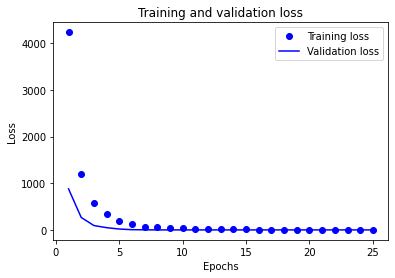

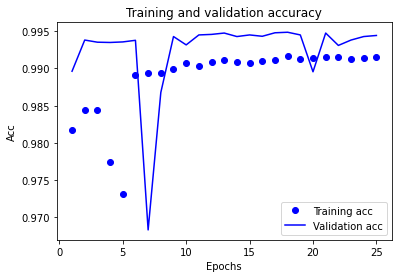

In [ ]:
y_pred =np.argmax(model.predict(X_test),axis=1)

target_names = ['1', '0']
print(metrics.classification_report(y_test, y_pred,
    target_names = target_names))
 
history_dict = history.history
loss, accuracy = model.evaluate(X_test, y_test)
 
print('test loss: ', loss)
print('test accuracy: ', accuracy)
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()# 
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
 
plt.plot(epochs, acc_values, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

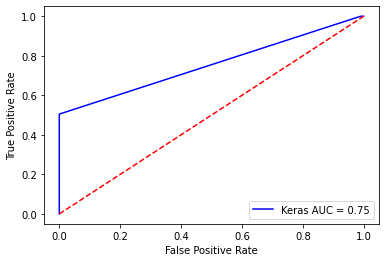

In [ ]:

y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_pred_keras)   
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, 'b', label='Keras AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()